In [1]:
from IPython.display import display
from IPython.display import Image

**Main contributor:** F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is using mass attenuation coefficients comparable with those from [NIST's XCOM](https://dx.doi.org/10.18434/T48G6X) Photon Cross Sections Database. 

**Material and Methods:** To generate an X-ray image with an analytic simulation, we must solve the [Beer-Lambert law](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law), which relies on attenuation coefficients. The first step in validating gVirtualXRay is to ascertain that the attenuation coefficients used in gVirtualXRay are in perfect agreement with those found in the literature. Ground truth data is provided in the [NIST Standard Reference Database 126](https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients).

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

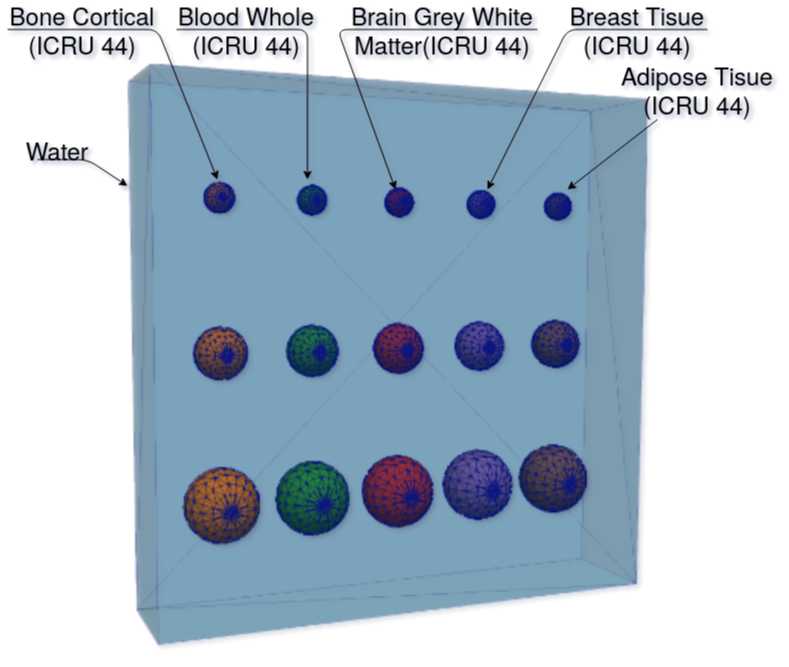

In [2]:
Image(filename="doc/sample.png", width=400)

**Results:** The correlation coefficient between the attenuation coefficients computed with gVirtualXRay and those provided in NIST's *XCOM: Photon Cross Sections Database* is 100% for bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue. It demonstrates that the photon cross section calculations performed in gVirtualXRay are accurate. 

# Import packages

In [3]:
%matplotlib inline

import os # Locate files

import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
import matplotlib.pyplot as plt # Plotting
import matplotlib.image as mpimg # Read file

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient
from sklearn.metrics import mean_absolute_percentage_error as mape

import viewscad # Use OpenSCAD to create STL files
from gvxrPython3 import gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.1.7 (2022-06-30T14:42:37) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.7 (2022-06-30T14:42:37) [Compiler: GNU g++] on Linux


In [4]:
if not os.path.exists("gVirtualXRay_output_data"):
    os.makedirs("gVirtualXRay_output_data")
    
if not os.path.exists("plots"):
    os.makedirs("plots")

# Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [5]:
json2gvxr.initGVXR("notebook-1.json", "EGL")

Create an OpenGL context: 800x450


0

1.5
4.5.0 NVIDIA 515.48.07
NVIDIA Corporation
NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
4.5.0 NVIDIA 515.48.07



# Creating the test object

We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files.

In [6]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fn=25);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([offset, 0, 0])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [7]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([70, 70, 15])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [8]:
fname = 'CAD_models/matrix.stl'
if not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_matrix_str + openscad_make_spheres_str, outfile='CAD_models/matrix.stl')

In [9]:
openscad_cube_str = """

color("red")
    scale([70, 70, 15])
        cube(1, center = true);

"""

In [10]:
fname = 'CAD_models/cube.stl'
if not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_cube_str, outfile=fname)

The spheres

In [11]:
openscad_col_str_set = []

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");")

    fname = 'CAD_models/col_' + str(i) + '.stl'
    if not os.path.isfile(fname):

        r = viewscad.Renderer()
        r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile=fname)

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [12]:
json2gvxr.initSamples(verbose=2)

Load the 3D data

Bone_Cortical_ICRU_44: d=1.92 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.034
        +el: name=Carbon ; f=0.155
        +el: name=Nitrogen ; f=0.042
        +el: name=Oxygen ; f=0.435
        +el: name=Sodium ; f=0.001
        +el: name=Magnesium ; f=0.002
        +el: name=Phosphor ; f=0.103
        +el: name=Sulfur ; f=0.003
        +el: name=Calcium ; f=0.225

Blood_Whole_ICRU_44: d=1.06 g/cm3 ; n=10 ; state=solid
        +el: name=Hydrogen ; f=0.102
        +el: name=Carbon ; f=0.11
        +el: name=Nitrogen ; f=0.033
        +el: name=Oxygen ; f=0.745
        +el: name=Sodium ; f=0.001
        +el: name=Phosphor ; f=0.001
        +el: name=Sulfur ; f=0.002
        +el: name=Chlorine ; f=0.003
        +el: name=Potassium ; f=0.002
        +el: name=Iron ; f=0.001

Brain_Grey_White_Matter_ICRU_44: d=1.04 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.107
        +el: name=Carbon ; f=0.145
        +el: name=Nitrogen ; f=0.022
        +el

CAD_models/col_0.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-2.99606, -2.19961, -0.496354)	(-2, 2.49901, 0.496354)
CAD_models/col_1.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-1.74606, -2.19961, -0.496354)	(-0.75, 2.49901, 0.496354)
CAD_models/col_2.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-0.496057, -2.19961, -0.496354)	(0.5, 2.49901, 0.496354)
CAD_models/col_3.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(0.753943, -2.19961, -0.496354)	(1.75, 2.49901, 0.496354)
CAD_models/col_4.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(2.00394, -2.19961, -0.496354)	(3, 2.49901, 0.496354)
CAD_models/cube.stl	nb_faces:	12	nb_vertices:	36	bounding_box (in cm):	(-3.5, -3.5, -0.75)	(3.5, 3.5, 0.75)


# Mass attenuation coefficients

Before computing an X-ray image, we can check that the mass attenuation coefficients are accurate. We downloaded tabulated data from the XCOM database and compare the values with the ones used in gVirtualXRay. 

## Chemical elements

We do it for relevant chemical elements from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html):

- [Carbon](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z06.html)
- [Chlorine](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z17.html)
- [Hydrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z01.html)
- [Iron](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z26.html)
- [Magnesium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z12.html)
- [Nitrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z07.html)
- [Oxygen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z08.html)
- [Phosphorus](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z15.html)
- [Potassium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z19.html)
- [Sodium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z11.html)
- [Sulfur](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z16.html)

Element    &    Pearson correlation    &    MAPE \\
\hline
Carbon    &    100.00\%    &    0.02\% \\
Chlorine    &    100.00\%    &    0.10\% \\
Hydrogen    &    100.00\%    &    0.01\% \\
Iron    &    100.00\%    &    0.11\% \\
Magnesium    &    100.00\%    &    0.10\% \\
Nitrogen    &    100.00\%    &    0.02\% \\
Oxygen    &    100.00\%    &    0.01\% \\
Potassium    &    100.00\%    &    0.12\% \\
Sodium    &    100.00\%    &    0.10\% \\
Sulfur    &    100.00\%    &    0.11\% \\
Overall    &    100.00\%$\pm$0.00    &    0.07\%$\pm$0.05 \\


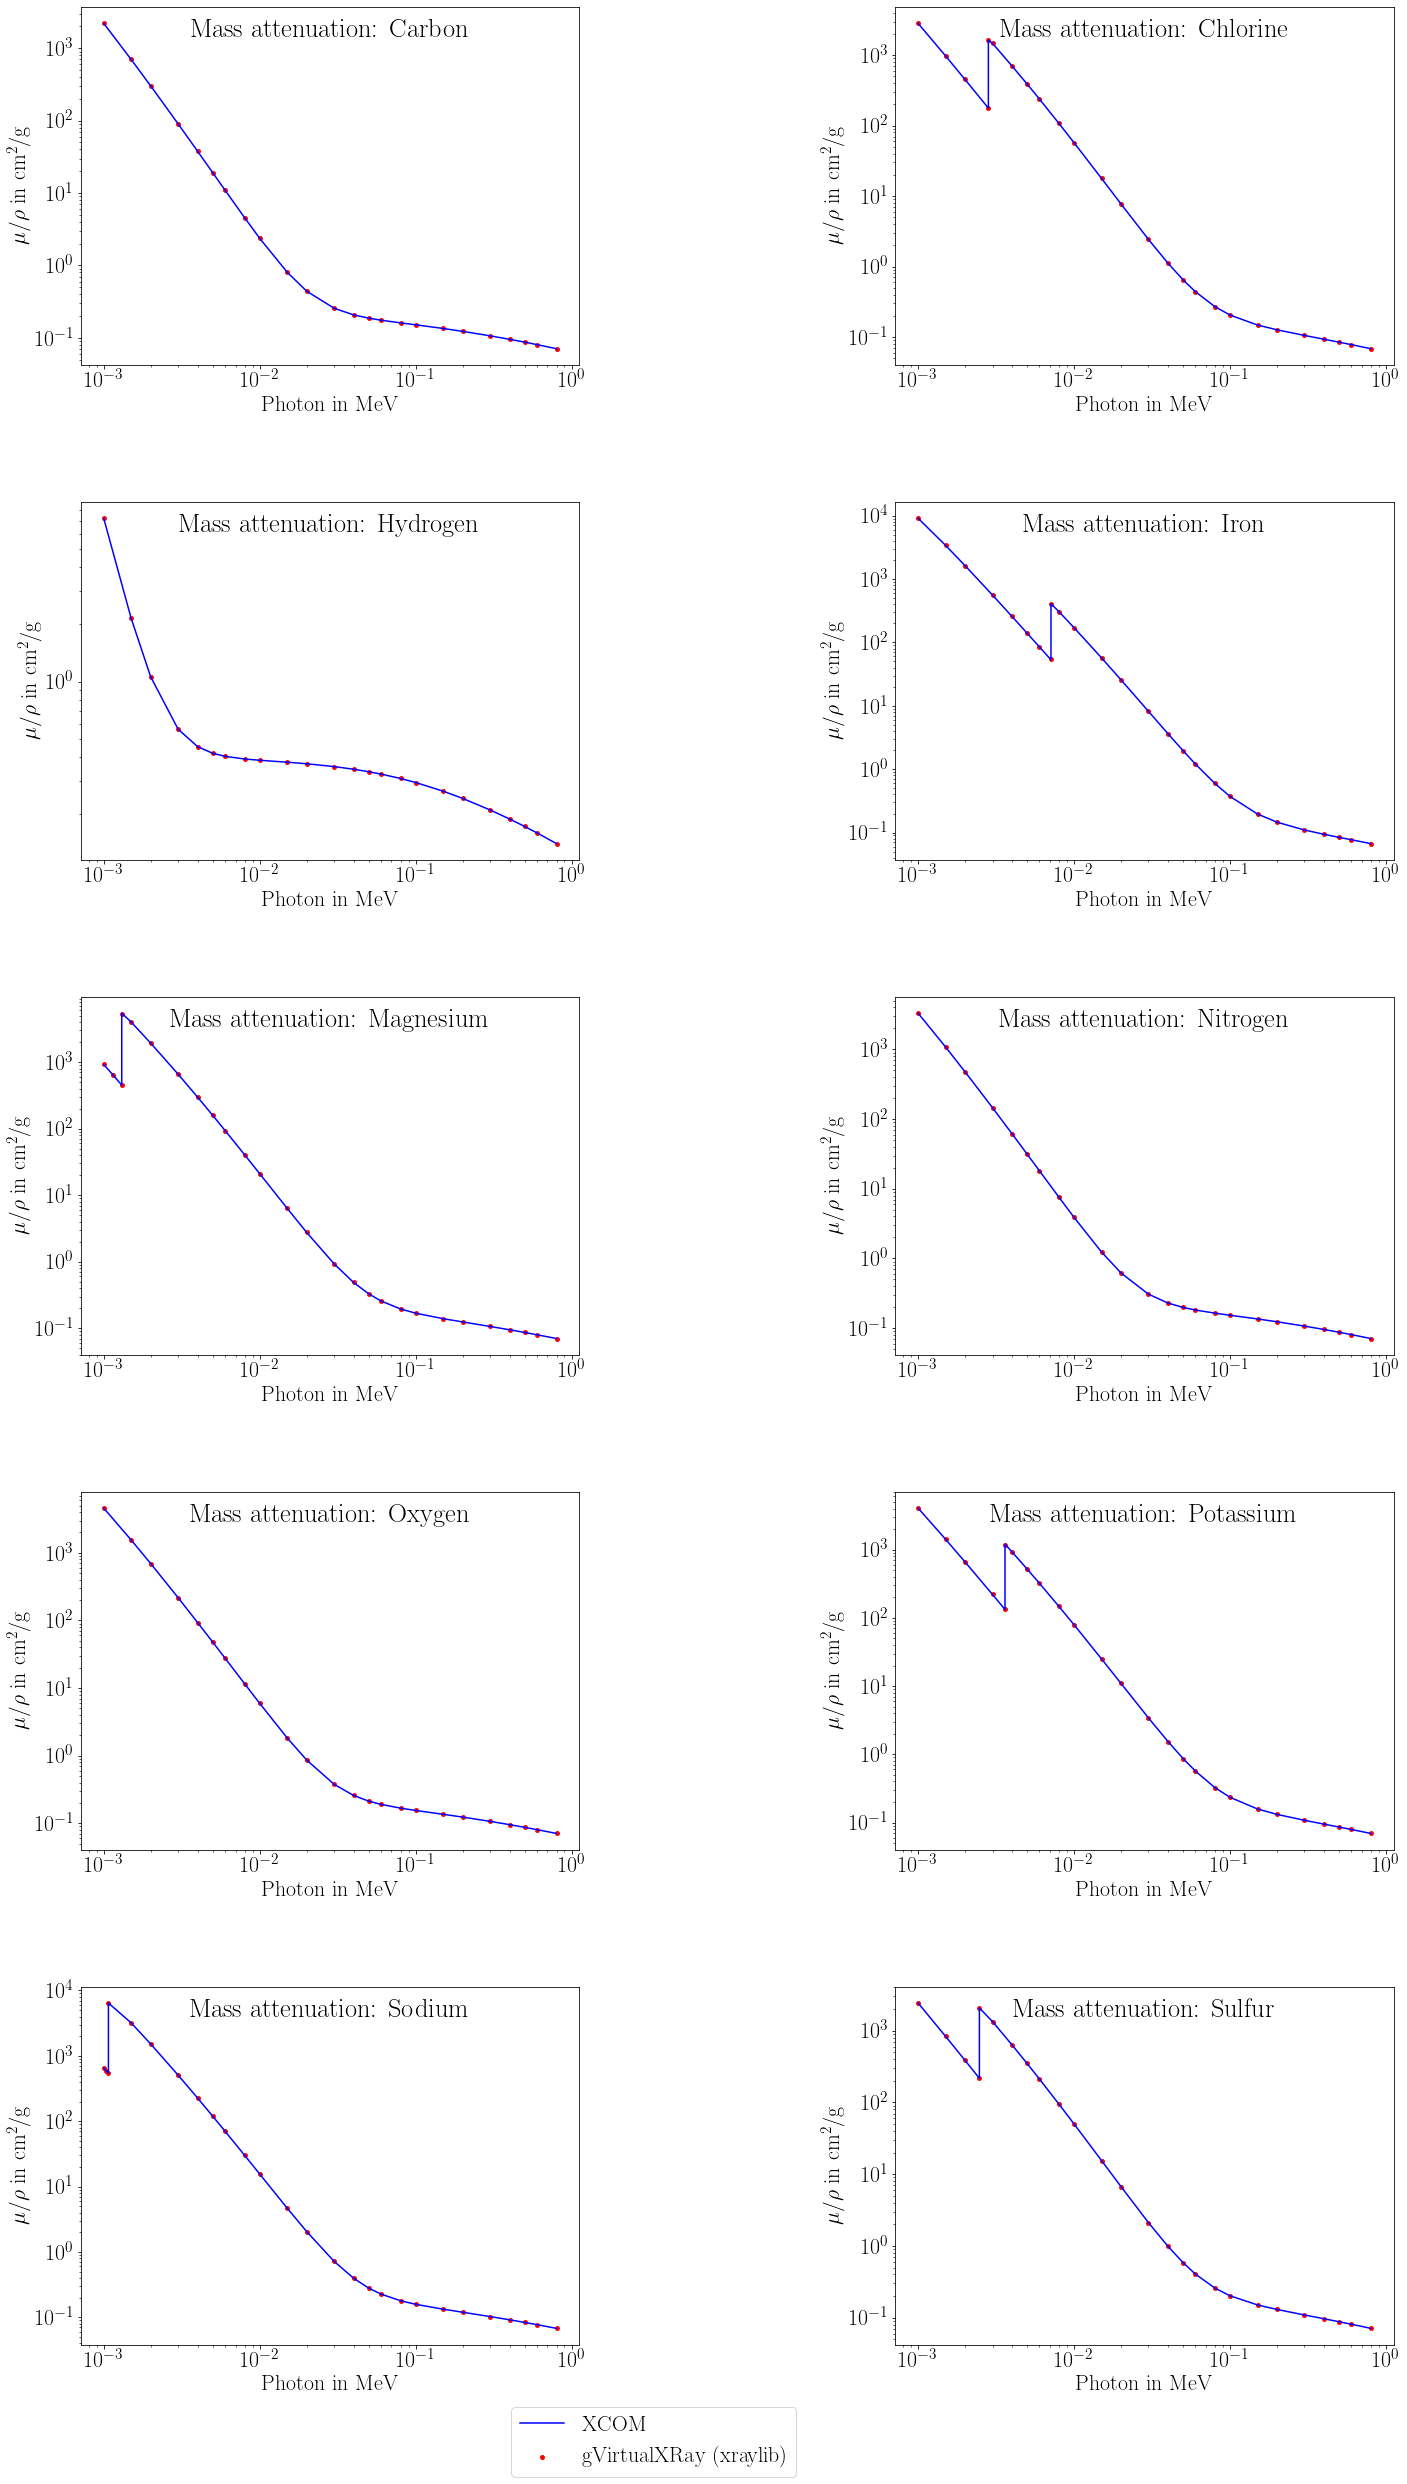

In [13]:
elements = ["Carbon", "Chlorine", "Hydrogen", "Iron", "Magnesium", "Nitrogen", "Oxygen", "Potassium", "Sodium", "Sulfur"] #  "Phosphorus"]#, ]

i = 1

plt.figure(figsize= (20,40))

cols = ["Element", "Pearson correlation (in %)", "MAPE (in %)"]
rows = []

print("Element    &    Pearson correlation    &    MAPE \\\\")
print("\\hline")

for element in elements:
    if os.path.isfile("XCOM_data/" + element + ".csv"):
        df = pd.read_csv("XCOM_data/" + element + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []
        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 0.005
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 0.005
            else:
                energy = df["Photon in MeV"][energy_id]
            
            gvxr_mu_rho.append(gvxr.getMassAttenuationFromElement(element, energy, "MeV"))
            gvxr_energy.append(energy)
        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        test = df["Photon in MeV"] < 1.0
        if df[test]["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df[test]["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df[test]["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())
        
        df.to_csv("gVirtualXRay_output_data/" + element + "-validation.csv", index=False )
        
        plt.subplot(6, 2, i)
        plt.title("Mass attenuation:  " + element, y=0.90)
        plt.plot(df[test]["Photon in MeV"], df[test]["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(df[test]["Photon in MeV"], df[test]["Mass attenuation coefficient (gVirtualXRay)"], label="gVirtualXRay (xraylib)", s=15, color="r")
        # plt.legend()
        plt.xlabel('Photon in MeV')
        plt.ylabel('${\\mu}/{\\rho}$ in cm$^2$/g')
        plt.xscale('log')
        plt.yscale('log')
        
        corr, _ = pearsonr(df[test]["Mass attenuation coefficient"], df[test]["Mass attenuation coefficient (gVirtualXRay)"])
        MAPE = mape(df[test]["Mass attenuation coefficient"], df[test]["Mass attenuation coefficient (gVirtualXRay)"])

        row = [element, 100.0 * corr, 100.0 * MAPE]
        rows.append(row)
        
        percent = "%"
        print(element + "    &    %.2f" % (100 * corr) + "\\" +  percent + "    &    %.2f" % (100 * MAPE) + "\\" +  percent + " \\\\")

        if i == 9:
            plt.legend(loc='lower center', bbox_to_anchor=(0.9, -0.4, 0.5, 0.5))

        i = i + 1

df = pd.DataFrame(columns=cols, data=rows)
print("Overall" + "    &    %.2f" % (df["Pearson correlation (in %)"].mean()) + "\\" + percent + "$\\pm$%.2f" % (df["Pearson correlation (in %)"].std()) + 
      "    &    %.2f" % (df["MAPE (in %)"].mean()) + "\\" + percent + "$\\pm$%.2f" % (df["MAPE (in %)"].std()) + " \\\\")
        
plt.tight_layout()

plt.savefig('plots/mass_attenuation_coefficients_from_elements.pdf')
plt.savefig('plots/mass_attenuation_coefficients_from_elements.png')

In [14]:
display(df)

,Element,Pearson correlation (in %),MAPE (in %)
0,Carbon,99.999999,0.015874
1,Chlorine,99.999291,0.098593
2,Hydrogen,99.999999,0.010194
3,Iron,99.999986,0.113902
4,Magnesium,99.997258,0.103033
5,Nitrogen,99.999998,0.015988
6,Oxygen,100.000000,0.012760
7,Potassium,99.999464,0.115588
8,Sodium,99.998418,0.098474
9,Sulfur,99.998309,0.113474


In [15]:
print("The smallest Pearsons correlation is %.2f" % df["Pearson correlation (in %)"].min() + "%")
print("The largest MAPE is %.2f" % df["MAPE (in %)"].max() + "%")

The smallest Pearsons correlation is 100.00%
The largest MAPE is 0.12%


The smallest Pearsons correlation is 100%, it is as good as it can get. The largest MAPE is about 0.12%, which is an extremely small error. When we plot the data generated with gVirtualXRay against NIST's, we cannot tell the difference. 

## ICRU-44 materials

We can now try something more complex, some clinically relevant materials from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html):

- [Adipose Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/adipose.html)
- [Blood, Whole (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/blood.html)
- [Bone, Cortical (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html)
- [Brain, Grey/White Matter (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/brain.html)
- [Breast Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/breast.html)
- [Water, Liquid](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/water.html)

Material    &    Pearson correlation    &    MAPE \\
\hline
Bone, Cortical    &    100.00\%    &    0.16\% \\
Blood, Whole    &    100.00\%    &    0.10\% \\
Brain, Grey, White, Matter    &    100.00\%    &    0.10\% \\
Breast, Tissue    &    100.00\%    &    0.08\% \\
Adipose, Tissue    &    100.00\%    &    0.08\% \\
H2O    &    100.00\%    &    0.01\% \\
Overall    &    100.00\%$\pm$0.00    &    0.09\%$\pm$0.05 \\


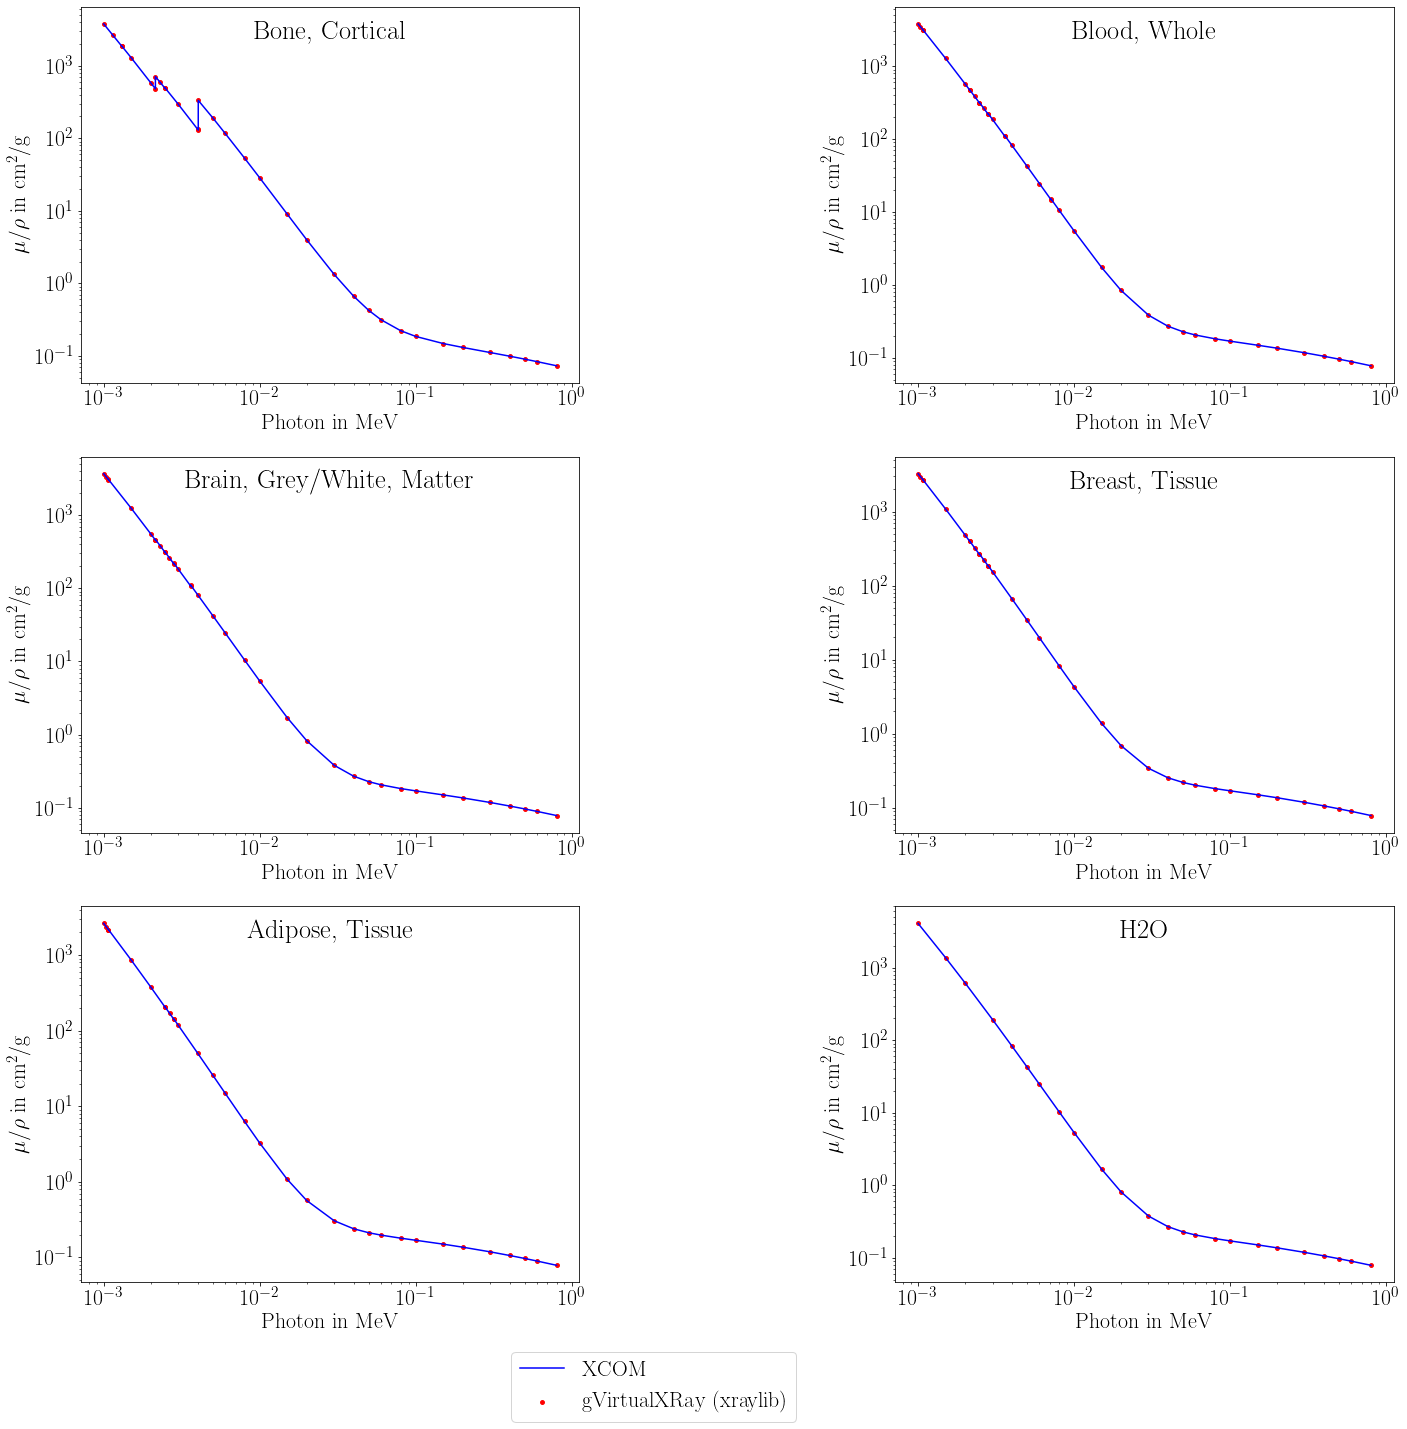

In [16]:
i = 1

plt.figure(figsize= (20,20))

min_pearsons_correlation = 100.0 # initialise with the largest possible value, +100%
max_MAPE = -100.0 # initialise with the smallest possible value, -100%

cols = ["Material", "Pearson correlation (in %)", "MAPE (in %)"]
rows = []

print("Material    &    Pearson correlation    &    MAPE \\\\")
print("\\hline")

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    if os.path.isfile("XCOM_data/" + label + ".csv"):
        df = pd.read_csv("XCOM_data/" + label + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []

        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 1e-3
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 1e-3
            else:
                energy = df["Photon in MeV"][energy_id]

            gvxr_mu_rho.append(gvxr.getMassAttenuationCoefficient(label, energy, "MeV"))
            gvxr_energy.append(energy)

        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        test = df["Photon in MeV"] < 1.0

        if df[test]["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df[test]["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df[test]["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())

        df.to_csv("gVirtualXRay_output_data/" + label + "-validation.csv", index=False)
        
        plt.subplot(3, 2, i)
        plt.title(label.replace('_ICRU_44','').replace('Grey_White','Grey/White').replace('_',', '), y=0.90)
        plt.plot(df[test]["Photon in MeV"], df[test]["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(df[test]["Photon in MeV"], df[test]["Mass attenuation coefficient (gVirtualXRay)"], label="gVirtualXRay (xraylib)", s=15, color="r")
        plt.xlabel('Photon in MeV')
        plt.ylabel('${\\mu}/{\\rho}$ in cm$^2$/g')
        plt.xscale('log')
        plt.yscale('log')
        
        corr, _ = pearsonr(df[test]["Mass attenuation coefficient"], df[test]["Mass attenuation coefficient (gVirtualXRay)"])
        MAPE = mape(df[test]["Mass attenuation coefficient"], df[test]["Mass attenuation coefficient (gVirtualXRay)"])
        
        label = label.replace("_ICRU_44", "")
        label = label.replace("_", ", ")
        
        row = [label, 100.0 * corr, 100.0 * MAPE]
        rows.append(row)

        percent = "%"
        print(label + "    &    %.2f" % (100 * corr) + "\\" + percent + "    &    %.2f" % (100 * MAPE) + "\\" + percent + " \\\\")
        
        if i == 5:
            plt.legend(loc='lower center', bbox_to_anchor=(0.9, -0.4, 0.5, 0.5))

        i = i + 1
        

df = pd.DataFrame(columns=cols, data=rows)
print("Overall" + "    &    %.2f" % (df["Pearson correlation (in %)"].mean()) + "\\" + percent + "$\\pm$%.2f" % (df["Pearson correlation (in %)"].std()) + 
      "    &    %.2f" % (df["MAPE (in %)"].mean()) + "\\" + percent + "$\\pm$%.2f" % (df["MAPE (in %)"].std()) + " \\\\")

plt.tight_layout()

plt.savefig('plots/mass_attenuation_coefficients_from_ICRU44.pdf')
plt.savefig('plots/mass_attenuation_coefficients_from_ICRU44.png')

In [17]:
display(df)

,Material,Pearson correlation (in %),MAPE (in %)
0,"Bone, Cortical",99.999301,0.164400
1,"Blood, Whole",99.999657,0.104904
2,"Brain, Grey, White, Matter",99.999402,0.099571
3,"Breast, Tissue",99.999616,0.083193
4,"Adipose, Tissue",99.999562,0.078368
5,H2O,100.000000,0.013099


## Worse case scenario

In [18]:
print("The smallest Pearsons correlation is %.2f" % df["Pearson correlation (in %)"].min() + "%")
print("The largest MAPE is %.2f" % df["MAPE (in %)"].max() + "%")

The smallest Pearsons correlation is 100.00%
The largest MAPE is 0.16%


In [19]:
print("The smallest Pearsons correlation is %.2f" % df["Pearson correlation (in %)"].min() + "%")
print("The largest MAPE is %.2f" % df["MAPE (in %)"].max() + "%")

The smallest Pearsons correlation is 100.00%
The largest MAPE is 0.16%


The smallest Pearsons correlation is 100%, it is as good as it can get. The largest MAPE is about 0.16%, which is an extremely small error.

# Shuting down

In [20]:
gvxr.destroyAllWindows()


0(0x556ba01a5390)
